# Figure 4 plotting

In [1]:
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())

import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

data_folder='/nfs/team205/vk8/processed_data/muscle/data_v3/'

import plotnine

In [2]:
import scvi

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"
Global seed set to 0


In [3]:
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

In [4]:
def calcul_plot_prop_box2(adata_input, ctype_anno, sample_anno="SampleID", donor_anno="DonorID",
                          age_group="Age_bin", filt_samples=True, subset_rm=[], subset_sel=[], pairs=[],
                          plot_save='', save_dir=''):
    if filt_samples == True:
        samples = adata_input.obs['SampleID'].value_counts().index[adata_input.obs['SampleID'].value_counts() > 1000]
        adata_obs = adata_input.obs.loc[adata_input.obs['SampleID'].isin(samples), :].copy()
    else:
        adata_obs = adata_input.obs.copy()

    if len(subset_rm) > 0:
        adata_obs = adata_obs.loc[~adata_obs[ctype_anno].isin(subset_rm)].copy()

    adata_obs[ctype_anno].cat.remove_unused_categories(inplace=True)
    sample2pop = adata_obs.groupby([sample_anno, ctype_anno]).count()[['n_counts']] / \
                 adata_obs.groupby([sample_anno]).count()[['n_counts']]
    sample2pop.reset_index(inplace=True)
    if len(subset_sel) > 0:
        sample2pop = sample2pop.loc[sample2pop[ctype_anno].isin(subset_sel)].copy()
        sample2pop[ctype_anno].cat.remove_unused_categories(inplace=True)
        sample2pop[ctype_anno] = sample2pop[ctype_anno].cat.reorder_categories(subset_sel).copy()
    age2donor2sample = adata_obs[[age_group, donor_anno, sample_anno]][
        ~adata_obs[[age_group, donor_anno, sample_anno]].duplicated()]
    age2d2s2ctype = age2donor2sample.merge(sample2pop, how="left", left_on=sample_anno, right_on=sample_anno)
    d2ctype = age2d2s2ctype.groupby([donor_anno, ctype_anno]).mean()['n_counts'].reset_index()
    age2donor = age2d2s2ctype[[age_group, donor_anno]][
        ~age2d2s2ctype[[age_group, donor_anno]].duplicated()].reset_index(drop=True)
    age2d2ctype = age2donor.merge(d2ctype, how="left", left_on=donor_anno, right_on=donor_anno)
    #age2d2ctype[age_group] = age2d2ctype[age_group].cat.reorder_categories(['young', 'old'])
    with matplotlib.rc_context({'axes.facecolor': 'black'}):
        rcParams['pdf.fonttype'] = 42
        rcParams['figure.figsize'] = [4, 4]
        import seaborn as sns
        sns.set_style(style="ticks")
        sns.set_context("paper")
        # sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
        # sns.set_style("ticks")
        # Draw a nested barplot by species and sex
        bp = sns.boxplot(
            data=age2d2ctype,
            x=ctype_anno, y="n_counts", hue=age_group, linewidth=1.5,
            # notch=True,
            # showcaps=False,
            flierprops={"marker": "x"},
            #   boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "black"},
        )
        # 'MF_typeI', 'MF_typeII', 'MF_typeI-FAM189A2','MF_typeII-FAM189A2', 'MF_typeI-OTUD1', 'MF_typeII-OTUD1',
        # 'MF_typeII-TNFRSF12A-high'
        if len(pairs) == 0:
            pairs = []
            for i in age2d2ctype[ctype_anno].cat.categories:
                x = ((i, age2d2ctype[age_group].cat.categories[0]), (i, age2d2ctype[age_group].cat.categories[1]))
                pairs.append(x)
        from statannotations.Annotator import Annotator
        annot = Annotator(bp, pairs, data=age2d2ctype, x=ctype_anno, y="n_counts", hue=age_group)
        annot.configure(test='Mann-Whitney', comparisons_correction="BH", verbose=2)
        annot.apply_test()
        ax, test_results = annot.annotate()
        plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
        #        print(test_results)
        list_of_dict = []
        for i in range(0, len(test_results)):
            list_of_dict.append(test_results[i].data.__dict__)
        signif_tb = pd.DataFrame(list_of_dict)
        #       annot = Annotator(ax, [("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")], data=df, x=x, y=y, order=order)
        #       annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
        #       annot.apply_test()
        #       ax, test_results = annot.annotate()

        IZ_colors = ['#000000', "#ff0000"]
        bp = sns.stripplot(
            data=age2d2ctype, dodge=True, jitter=True, marker="D", alpha=1,
            x=ctype_anno, y="n_counts", hue=age_group, palette=IZ_colors, s=3,
        )
        plt.xticks(rotation=45)
        # bp.despine()
        # g.set_xticklabels(g.get_xticklabels(), rotation=30)
        # bp.set_axis_labels("", "Proportion of myofiber type")
        handles, labels = bp.get_legend_handles_labels()
        # specify just one legend
        l = plt.legend(handles[0:2], labels[0:2])
        # bp.legend.set_title("")
        plt.tight_layout()
        if len(plot_save) > 0:
            plt.savefig(f'{save_dir}/Boxplot2_{plot_save}.pdf', dpi=300, bbox_inches='tight')
        output = {'df': age2d2ctype, 'test_res': signif_tb}
    return (output)

In [5]:
model_folder = '/nfs/team205/vk8/scripts/scvi/Results/scvi_models/'
figures = '/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures'
tables = '/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/tables'
source_files = "/nfs/team205/vk8/scripts/scvi/SKM_ageing_atlas_SourceFiles/"

In [6]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

In [7]:
adata_nc = sc.read('/nfs/team205/vk8/processed_data/muscle/data_v3/updated_icm_snuclei/ICM_myonuclei_scvi1_dbrm_2023-05-07.h5ad')

In [9]:
adata_nc.obs['MYH7+'] = adata_nc[:,'MYH7'].X.todense()>0
adata_nc.obs['MYH1+'] = adata_nc[:,'MYH1'].X.todense()>0
adata_nc.obs['MYH2+'] = adata_nc[:,'MYH2'].X.todense()>0
adata_nc.obs['myofiber_type2'] = adata_nc.obs.\
apply(lambda x: 'MYH7+' if (x['MYH7+'] == True) & (x['MYH1+'] == False) & (x['MYH2+'] == False) else
      'MYH1+' if  (x['MYH7+'] == False) & (x['MYH1+'] == True) & (x['MYH2+'] == False) else
 'MYH2+' if  (x['MYH7+'] == False) & (x['MYH1+'] == False) & (x['MYH2+'] == True) else
    'MYH1+MYH2+' if (x['MYH7+'] == False) & (x['MYH1+'] == True) & (x['MYH2+'] == True) else
     'MYH1+MYH7+' if (x['MYH7+'] == True) & (x['MYH1+'] == True) & (x['MYH2+'] == False) else 
      'MYH2+MYH7+' if (x['MYH7+'] == True) & (x['MYH2+'] == True) & (x['MYH1+'] == False) else
      'MYH1+MYH2+MYH7+' if (x['MYH7+'] == True) & (x['MYH2+'] == True) & (x['MYH1+'] == True) else
      'nan', axis = 1)

In [10]:
adata_nc.obs.groupby(['DonorID', 'SampleID', '10X_version'], observed = True).mean()[['n_counts', 'n_genes']].sort_values('n_counts')

n_counts      n_genes
DonorID SampleID         10X_version                          
582C    WS_A_SKM10691779 3'v3          876.735535   530.267218
500C    5386STDY8493510  3'v2          966.959717   588.431699
470BR   5386STDY8090406  3'v2         1145.684692   675.436788
        5386STDY8090407  3'v2         1170.703247   695.483357
398B    5386STDY7796287  3'v2         1199.798950   633.969072
        5386STDY7796286  3'v2         1206.961792   658.289617
362C    5386STDY7600837  3'v2         1359.044312   708.056449
367C    5386STDY7645355  3'v2         1408.261108   770.810401
583B    WS_A_SKM10691778 3'v3         1421.940430   726.084541
362C    5386STDY7600836  3'v2         1439.570557   732.884615
566B    WS_A_SKM9426500  3'v3         1952.177612  1036.377532
339C    mus_SNuc7468111  3'v2         2252.446777   944.175582
362C    WS_A_SKM9426496  3'v3         2297.555908  1103.584094
464C    5386STDY8552614  3'v2/v3      2526.824951  1147.665929
        5386STDY8552613  3'v2/v3      2534.495850  1146.447641
502B    WS_A_SKM9426495  3'v3         2982.423096  1113.565916
470BR   5386STDY8552709  3'v2/v3      3028.176514  1223.699746
529C    WS_A_SKM9426501  3'v3         3539.259766  1460.576263
        WS_A_SKM9426502  3'v3         3599.880371  1466.671276
343B    WS_A_SKM9426497  3'v3         4061.525879  1167.568038
        WS_A_SKM9426498  3'v3         4130.879395  1180.887079
566B    WS_A_SKM9426499  3'v3         9024.173828  2807.559229

In [12]:
adata_nc.obs['myofiber_type'] = adata_nc.obs['myofiber_type'].cat.reorder_categories(new_categories = ['MYH7+', 'MYH2+', 'MYH1+', 'MYH1+MYH2+', 'MYH2+MYH7+', 'MYH1+MYH7+',\
                                                                   'MYH1+MYH2+MYH7+', 'nan']).copy()
adata_nc.uns['myofiber_type_colors'] = ['#1E88E5', '#00FF66', '#F44336', '#FFFF00', '#00796B', '#6C3483', '#BDBDBD', '#b5bd61']

In [13]:
adata_nc.obs['myofiber_type_filt'] = adata_nc.obs['myofiber_type_filt'].cat.reorder_categories(new_categories = ['MYH7+', 'MYH2+', 'MYH1+', 'MYH1+MYH2+', 'MYH2+MYH7+', 'MYH1+MYH7+',\
                                                                   'MYH1+MYH2+MYH7+', 'nan']).copy()
#adata_nc.uns['myofiber_type_colors'] = ['#1E88E5', '#00FF66', '#F44336', '#FFFF00', '#00796B', '#6C3483', '#BDBDBD', '#b5bd61']

In [14]:
adata_nc_filt = adata_nc[(adata_nc.obs['myofiber_type']!= 'nan') & 
                         (~adata_nc.obs['annotation_level1'].isin(['MF-IIsn(fg)', 'MF-Isn(fg)'])),:].copy()

In [15]:
adata_nc_filt.shape

(38480, 33538)

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


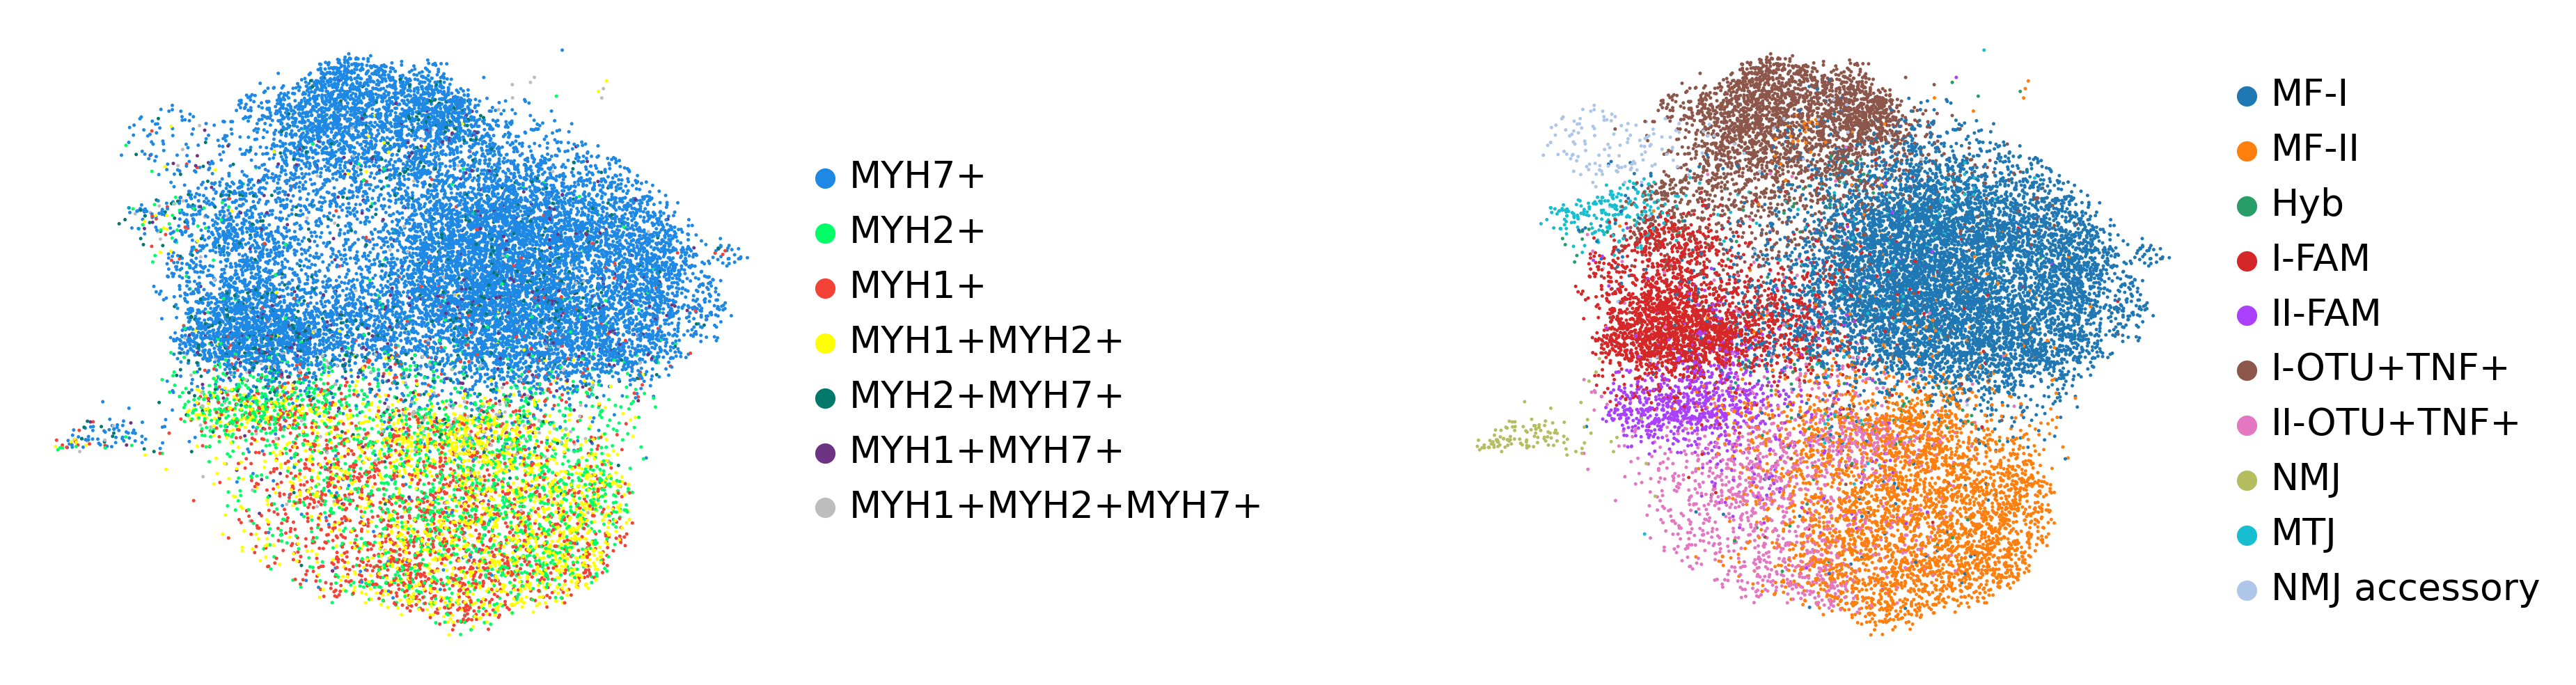

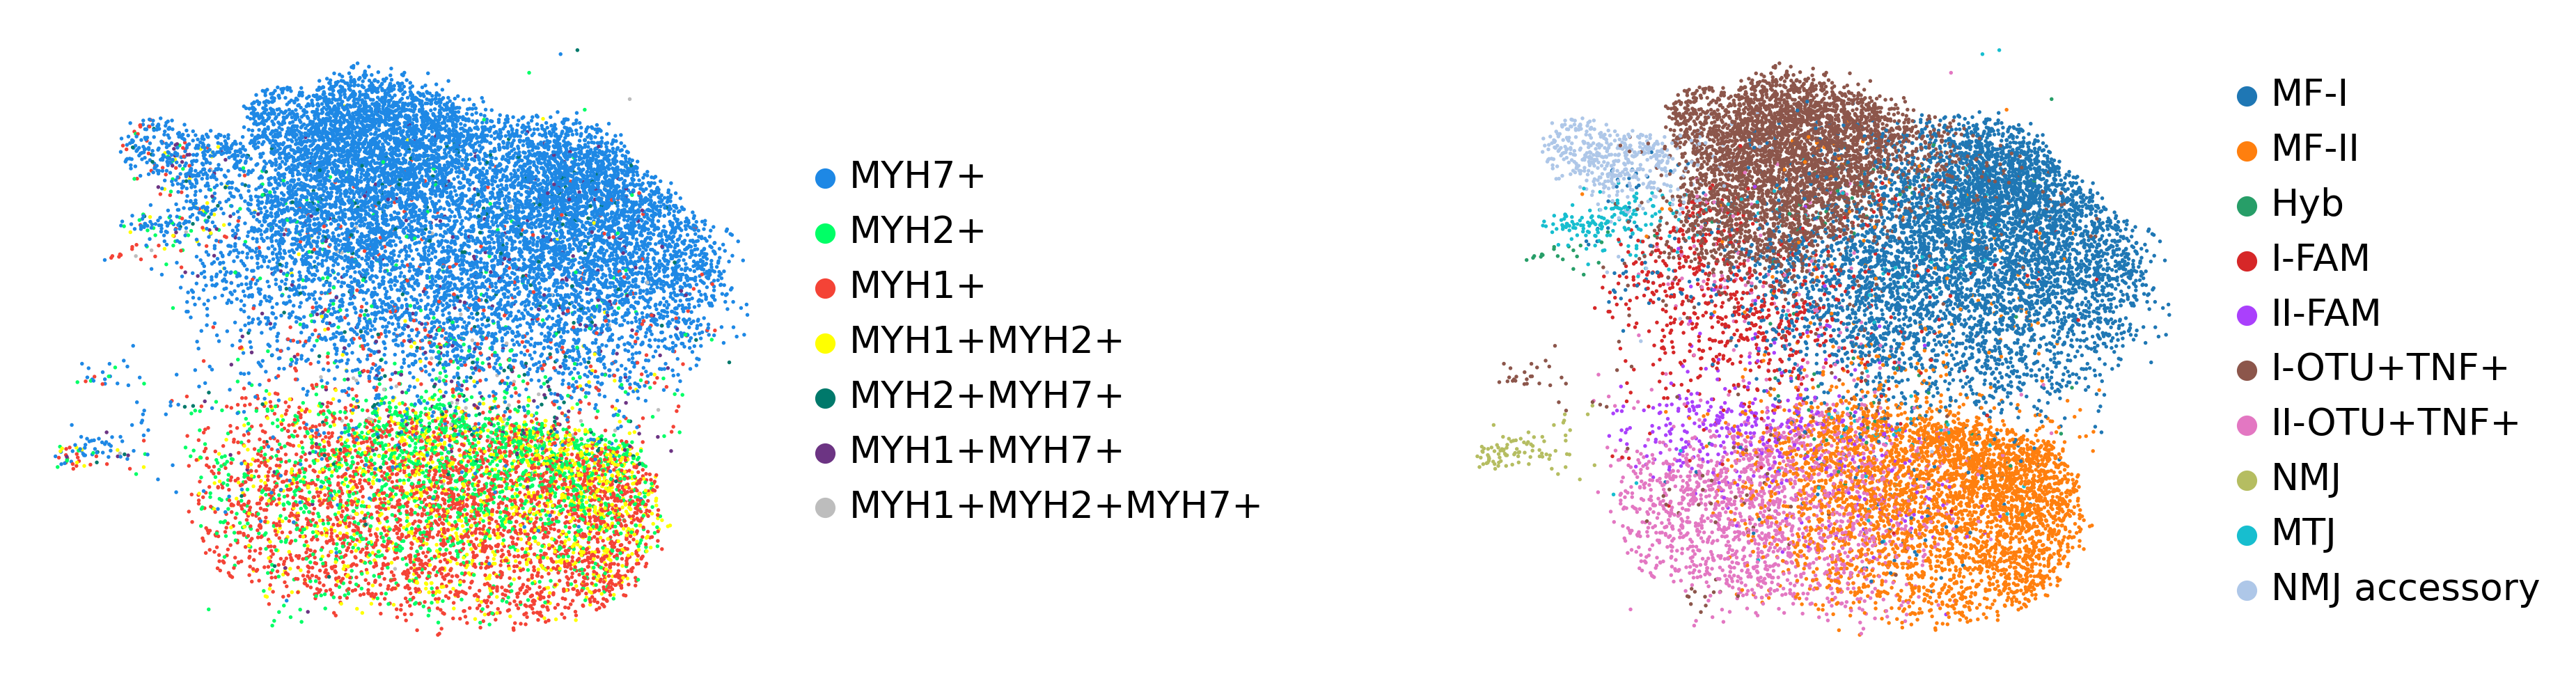

In [16]:
sc.pl.umap(adata_nc_filt[adata_nc_filt.obs['Age_group'] == 'young',:], color = ['myofiber_type','annotation_level1'],\
           frameon = False, title = ["", ""],wspace = 0.7, save = "Myofiber_type_young.pdf")
sc.pl.umap(adata_nc_filt[adata_nc_filt.obs['Age_group'] == 'old',:], color = ['myofiber_type','annotation_level1'],\
           frameon = False, title = ["", ""],wspace = 0.7, save = "Myofiber_type_old.pdf")

In [17]:
adata_nc.obs['myofiber_type_filt'].value_counts()

nan                36396
MYH7+              24516
MYH1+               5036
MYH2+               3841
MYH1+MYH2+          3085
MYH2+MYH7+           840
MYH1+MYH7+           637
MYH1+MYH2+MYH7+      275
Name: myofiber_type_filt, dtype: int64

In [19]:
adata_nc.obs['Age_group'] = adata_nc.obs['Age_group'].astype('category')

adata_nc.obs['Age_group'] = adata_nc.obs['Age_group'].cat.reorder_categories(['young', 'old'])

myofiber_order1 = ['MYH7+', 'MYH2+',  'MYH1+MYH2+', 'MYH1+','MYH2+MYH7+', 'MYH1+MYH7+','MYH1+MYH2+MYH7+', 'nan']
myofiber_order2 = ['MYH7+', 'MYH2+',  'MYH1+MYH2+', 'MYH1+','MYH2+MYH7+', 'MYH1+MYH7+','MYH1+MYH2+MYH7+']

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MYH2+_young vs. MYH2+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.357e-01 U_stat=1.900e+01
MYH7+_young vs. MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.338e-01 U_stat=2.600e+01
MYH1+MYH2+_young vs. MYH1+MYH2+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.206e-01 U_stat=1.800e+01
MYH1+_young vs. MYH1+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.343e-01 U_stat=1.200e+01
MYH2+MYH7+_young vs. MYH2+MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.343e-01 U_stat=3.000e+01
MYH1+MYH7+_young vs. MYH1+MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.338e-01 U_stat=2

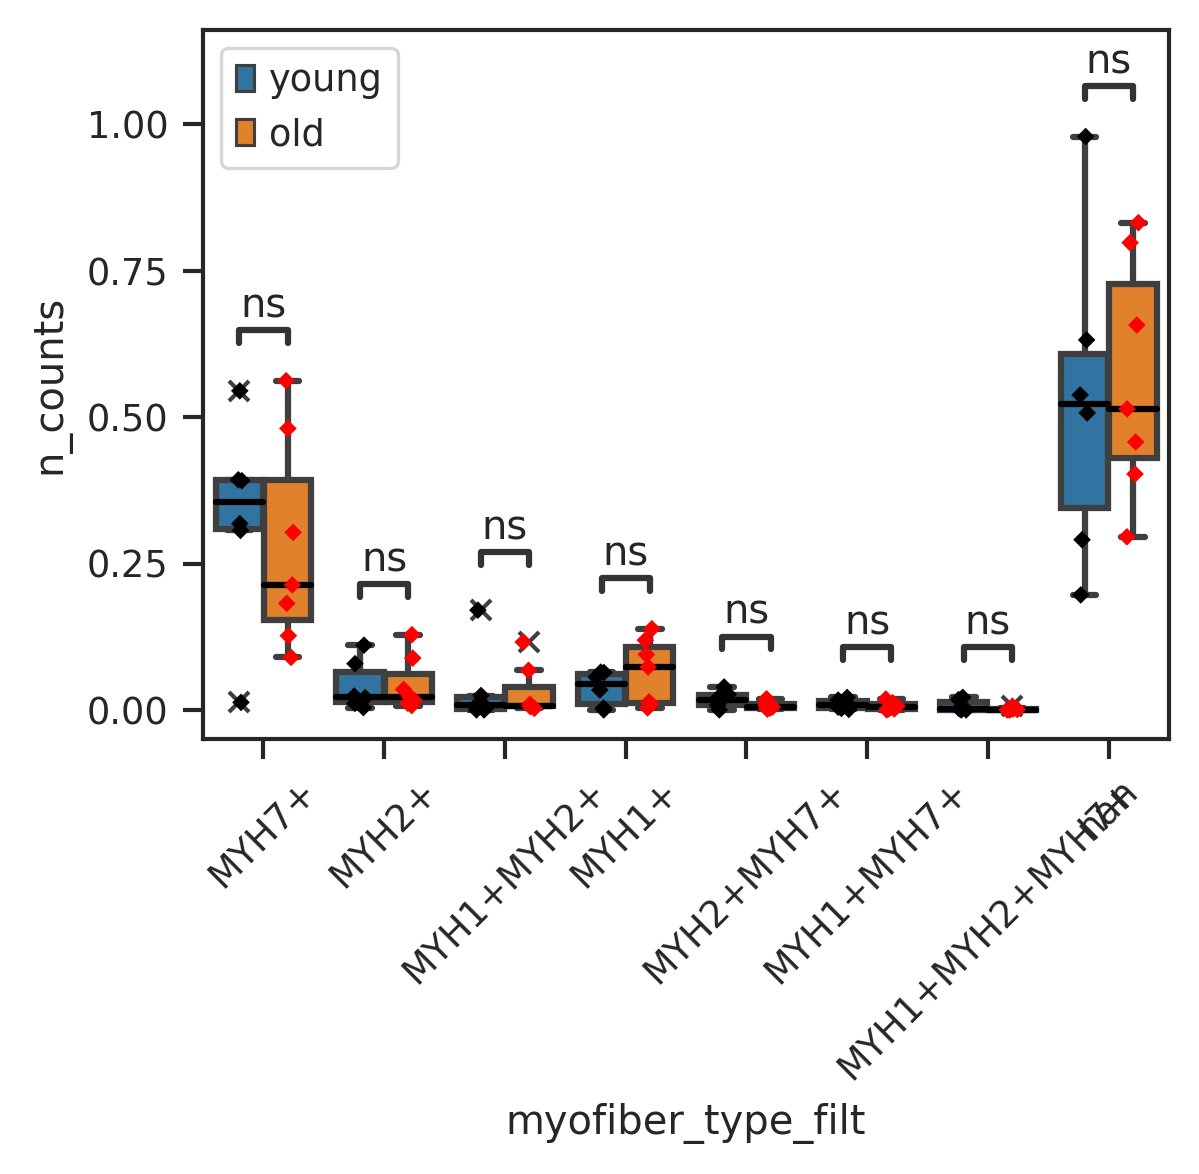

In [20]:
adata_nc2cel_all = calcul_plot_prop_box2(adata_nc, ctype_anno = 'myofiber_type_filt', sample_anno="SampleID", donor_anno="DonorID",
                          age_group="Age_group", filt_samples=False, subset_rm=[], 
                                     subset_sel=myofiber_order1, pairs=[],
                          plot_save='', save_dir='')

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MYH2+_young vs. MYH2+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.357e-01 U_stat=1.900e+01
MYH7+_young vs. MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.338e-01 U_stat=2.600e+01
MYH1+MYH2+_young vs. MYH1+MYH2+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.206e-01 U_stat=1.800e+01
MYH1+_young vs. MYH1+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.343e-01 U_stat=1.200e+01
MYH2+MYH7+_young vs. MYH2+MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.343e-01 U_stat=3.000e+01
MYH1+MYH7+_young vs. MYH1+MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.338e-01 U_stat=2

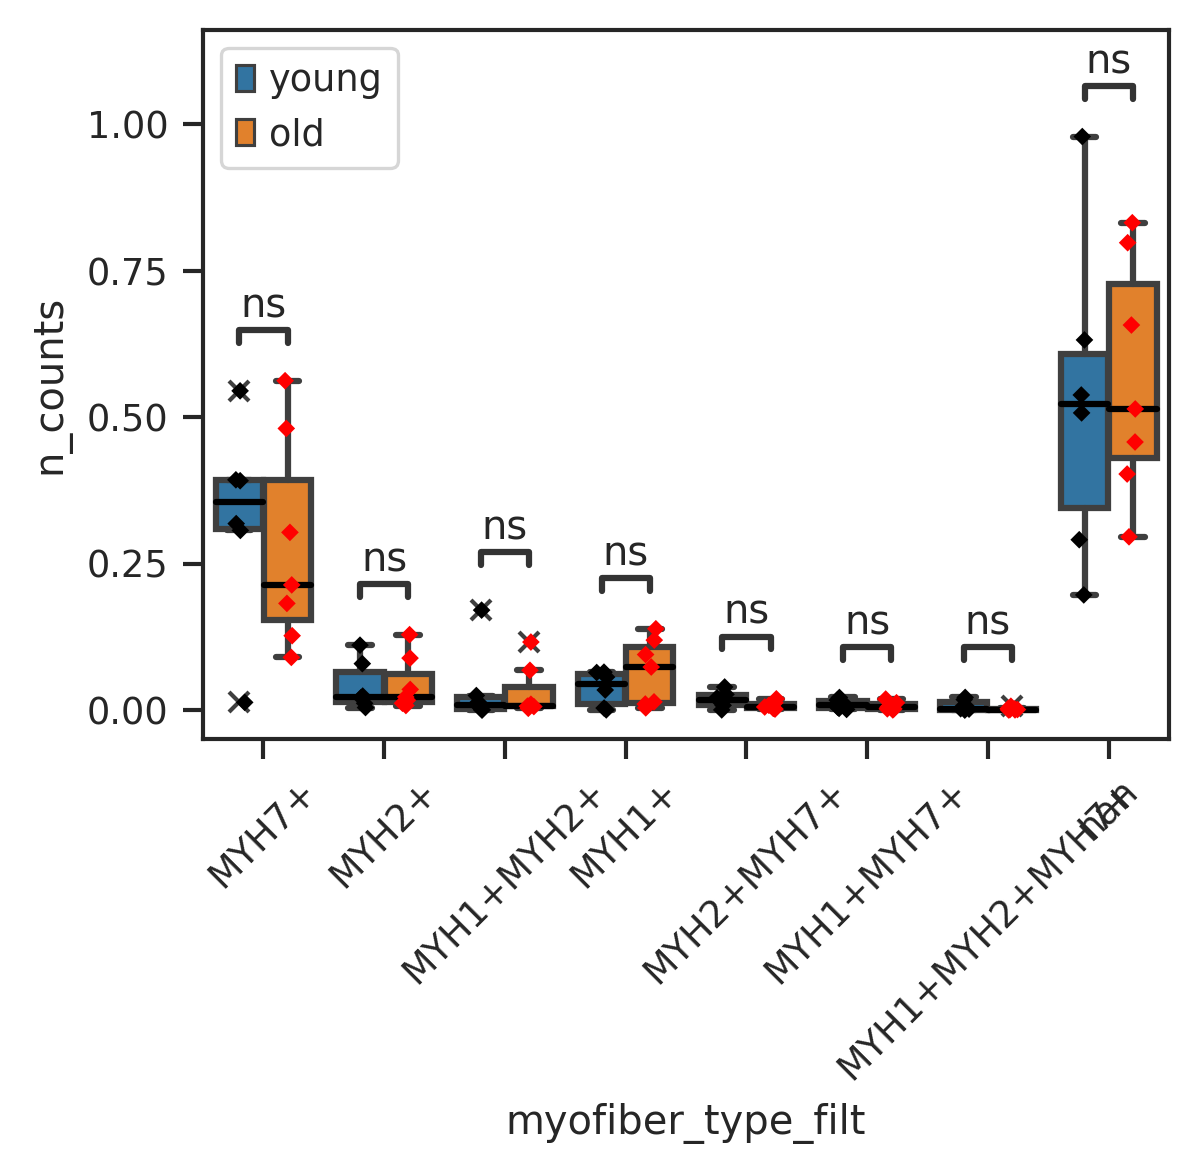

In [18]:
adata_nc2cel_all = calcul_plot_prop_box2(adata_nc, ctype_anno = 'myofiber_type_filt', sample_anno="SampleID", donor_anno="DonorID",
                          age_group="Age_group", filt_samples=False, subset_rm=[], 
                                     subset_sel=myofiber_order1, pairs=[],
                          plot_save='', save_dir='')

In [ ]:
/nfs/team205/vk8/processed_data/muscle/data_v3/updated_icm_snuclei/ICM_myonuclei_scvi1_dbrm_2023-05-07.h5ad

In [21]:
adata_nc

AnnData object with n_obs × n_vars = 74626 × 33538
    obs: 'SampleID', 'barcode', 'concat_sample_no', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', '10X_version', 'n_counts', 'n_counts_raw', 'percent_soup', 'n_counts_spliced', 'n_counts_unspliced', 'percent_spliced', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'Age_group', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'leiden', 'fine_predicted_labels', 'fine_over_clustering', 'fine_majority_voting', 'fine_conf_score', 'coarse_predicted_labels', 'coarse_over_clustering', 'coarse_majority_voting', 'coarse_conf_score', 'leiden_r1.6', 'leiden_r2', 'leiden_r3', 'leiden_r', 'manual_anno', 'myofiber_fine_predicted_labels', 'myofiber_fine_over_clustering', 'myofiber_fine_majority_voting', 'myofiber_fine_conf_score', 'manual_anno2', 'annotation_level0', 'annotation_level1', 'MYH7+', 'MYH1+', 'MYH2+', 'myofiber_type', 'myofiber_type_filt', 'myofiber_type2'
    var:

In [20]:
adata_nc.write('/nfs/team205/vk8/processed_data/muscle/data_v3/updated_icm_snuclei/ICM_myonuclei_scvi1_dbrm_2023-05-07_mftype_upd.h5ad')

In [27]:
adata_nc2cel_all['df'].to_csv(f'{tables}/Myonuclei_myofiber_types_incl_nan.csv', index = False)

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MYH2+_young vs. MYH2+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.357e-01 U_stat=2.300e+01
MYH7+_young vs. MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.308e-01 U_stat=2.400e+01
MYH1+MYH2+_young vs. MYH1+MYH2+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.314e-01 U_stat=1.500e+01
MYH1+_young vs. MYH1+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.949e-01 U_stat=1.300e+01
MYH2+MYH7+_young vs. MYH2+MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.343e-01 U_stat=3.000e+01
MYH1+MYH7+_young vs. MYH1+MYH7+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.807e-01 U_stat=3

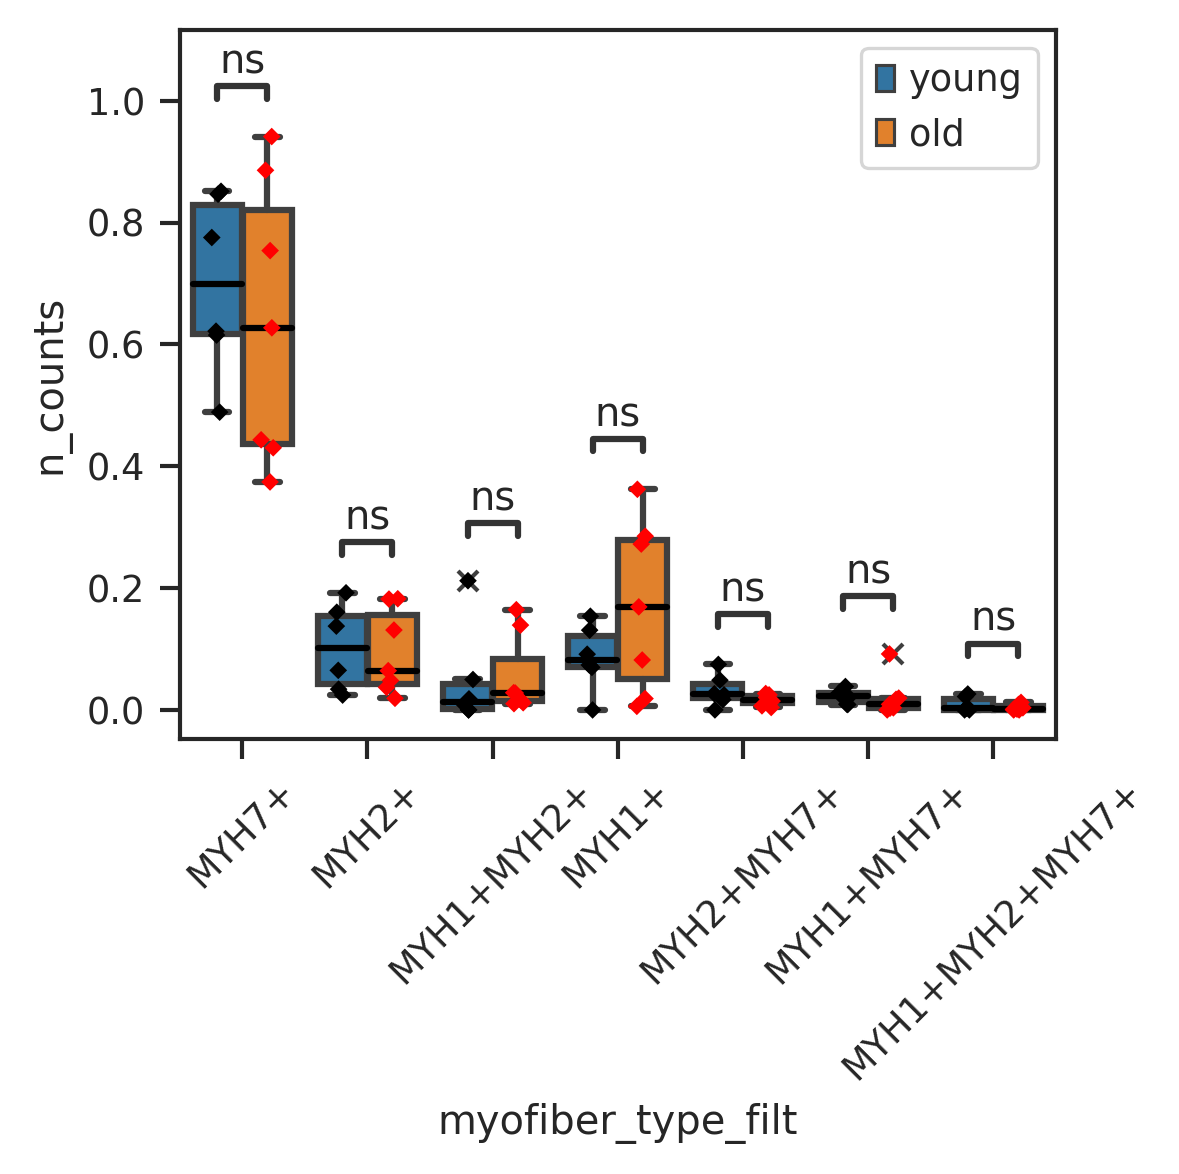

In [23]:
adata_nc2ce_na_filt = calcul_plot_prop_box2(adata_nc, ctype_anno = 'myofiber_type_filt', sample_anno="SampleID", donor_anno="DonorID",
                          age_group="Age_group", filt_samples=False, subset_rm=['nan'], 
                                     subset_sel=myofiber_order2, pairs=[],
                          plot_save='', save_dir='')

In [30]:
adata_nc2ce_na_filt['df'].to_csv(f'{tables}/Myonuclei_myofiber_types_nan_rm.csv', index = False)